In [28]:
a = [2,3,1]
b = np.greater(a,1)
c = np.where(b)
print c

(array([0, 1], dtype=int64),)


aaaaa
0.00100050025013
[[ 0.9856]] [[ 0.9856]] [[ 0.0275968]] [[ 0.0275968]]
[ 0.08690044]
[ -1.65679821e+14]


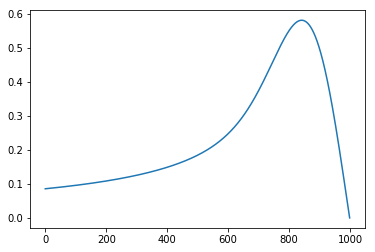

1000


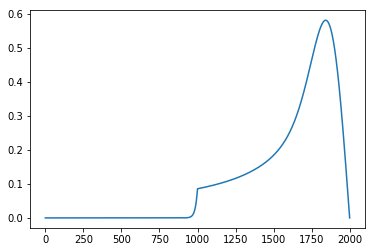

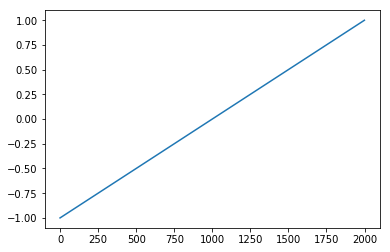

sum_c
0.243435289173
[ 0.08690044]
[ -1.65679821e+14]


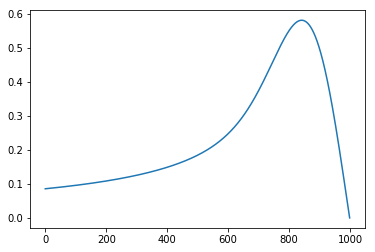

1000


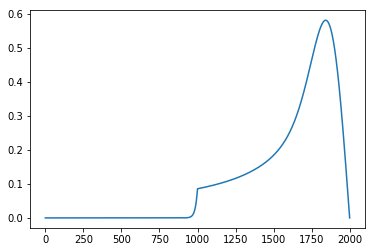

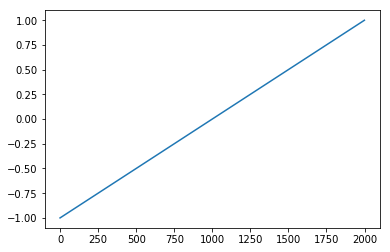

sum_c
0.243435289173


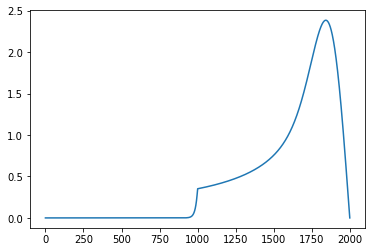

In [67]:
import numpy as np
from numpy.matlib import repmat
import scipy.stats
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from io import StringIO
from scipy import special

class ExtData:
    def __init__(self):
        self.etaE = None
        self.etaI = None
        self.fE   = 0.0
        self.fI   = 0.0
        # ON-OFF visual pathway
        self.etaON  = None
        self.fON    = 0.0
        self.etaOFF = None
        self.fOFF   = 0.0

class RecData:
    def __init__(self):
        self.mE = None
        self.mI = None
        self.SEE = 0.0
        self.SEI = 0.0
        self.SIE = 0.0
        self.SII = 0.0
        # LR connections
        self.LEE  = 0.0
        self.LIE  = 0.0
        self.LEEF = 0.0
        self.LIEF = 0.0
        print 'aaaaa'
        
        self.In   = None
        
class NetParams:
    def __init__(self):
        self.NHYP = 0
        self.NE   = 0
        self.NI   = 0
        # SETTING
        self.gL   = 0.0
        self.vL   = 0.0
        self.V    = None
        self.h    = 0.0
        self.N_divide = 0
        self.dt = 0.0
        self.Final_time = 0.0
        self.tauN  = 0.0

        
def VQs(Ext,Rec,NetParams):
    # EXTRACT FR 
    (etaE,etaI,fE,fI,etaON,etaOFF,fON,fOFF) = (Ext.etaE,Ext.etaI,Ext.fE,Ext.fI,Ext.etaON,Ext.etaOFF,Ext.fON,Ext.fOFF)
    (mE,mI,In,SEE,SEI,SIE,SII,LEE,LIE,LEEF,LIEF) = (Rec.mE,Rec.mI,Rec.In,Rec.SEE,Rec.SEI,Rec.SIE,
                                                    Rec.SII,Rec.LEE,Rec.LIE,Rec.LEEF,Rec.LIEF)
    (vL,gL,dt,tauN,NHYP) = (NetParams.vL,NetParams.gL,NetParams.dt,NetParams.tauN,NetParams.NHYP)
    # CALCULATE $i_{NMDA}(lT+T)$
    INMDA = np.zeros_like(In)
    for i in range(NHYP):
        # Exc<-Exc
        INMDA[i,0] = np.sum(LEE*mE*(1-np.exp(-dt/tauN))) - LEE*mE[i,0]*(1-np.exp(-dt/tauN))
        INMDA[i,1] = np.sum(LIE*mE*(1-np.exp(-dt/tauN))) - LIE*mE[i,0]*(1-np.exp(-dt/tauN))
    In = In*np.exp(-dt/tauN) + INMDA
    """
    VEs = (vL*gL+etaE*fE+SEE*mE-SEI*mI)/gL  # DO NOT TAKE LR INTO CONSIDERATION
    VIs = (vL*gL+etaI*fI+SIE*mE-SII*mI)/gL
    """
    
    VEs = (vL*gL+etaE*fE+SEE*mE-SEI*mI+(In[:,0]))/gL  # DO NOT TAKE LR INTO CONSIDERATION
    VIs = (vL*gL+etaI*fI+SIE*mE-SII*mI+(In[:,1]))/gL
           
    return (VEs,VIs,In)

def DQs(Ext,Rec,NetParams):
    # EXTRACT FR 
    (etaE,etaI,fE,fI,etaON,etaOFF,fON,fOFF) = (Ext.etaE,Ext.etaI,Ext.fE,Ext.fI,Ext.etaON,Ext.etaOFF,Ext.fON,Ext.fOFF)
    (mE,mI,In,SEE,SEI,SIE,SII,LEE,LIE,LEEF,LIEF) = (Rec.mE,Rec.mI,Rec.In,Rec.SEE,Rec.SEI,Rec.SIE,
                                                    Rec.SII,Rec.LEE,Rec.LIE,Rec.LEEF,Rec.LIEF)
    (vL,gL,dt,tauN,NE,NI) = (NetParams.vL,NetParams.gL,NetParams.dt,NetParams.tauN,NetParams.NE,NetParams.NI)
    # IGNORE $\sigma i_N$
    DE = (etaE*np.square(fE)+mE*np.square(SEE)/NE+mI*np.square(SEI)/NI)/gL
    DI = (etaI*np.square(fI)+mE*np.square(SIE)/NE+mI*np.square(SII)/NI)/gL
    return (DE,DI)

def rho_EQ(Vs,D,V):
    
    Rv = np.copy(V)
    (vT,vR) = (1.0,0.0)
    tmpg = np.greater(V,vR)
    indp = (np.where(tmpg))
    sqrtD  = np.sqrt(D)
    intovT  = special.dawsn((vT-Vs)/sqrtD)*np.exp(np.square(vT-Vs)/D)
    print intovT
    intovSD = special.dawsn(-Vs/sqrtD)*np.exp(np.square(Vs)/D)
    print intovSD
    # compute R with V>vR case:
    Rv[indp] = -special.dawsn((V[indp]-Vs)/sqrtD)+np.exp(-np.square(V[indp]-Vs)/D)*intovT
    plt.plot(Rv[indp])
    plt.show()
    print indp[0][0]
    if(indp[0][0]>1):
        Rv[0:indp[0][0]] = np.exp(-np.square(V[0:indp[0][0]]-Vs)/D)*(-intovSD + intovT)
    
    tmpl = np.less(V,-2.0/3.0)
    indp = np.where(tmpl)
    Rv[indp] = 0.0
    plt.plot(Rv)
    plt.show()
    sum_c = (V[2]-V[1])*np.sum(Rv)
    plt.plot(V)
    plt.show()
    print 'sum_c'
    print sum_c
    Rv = Rv/sum_c
    
    return (Rv,sum_c)
    

def Solve_moment_Python_CODE_method():
    Ext = ExtData()
    Rec = RecData()
    Net = NetParams()
    # NETWORK STRUCTURE
    (NE,NI,NHYP) = (100,100,1) #(300,100,3)
    (vL,gL,V_start,V_end,N_divide) = (0.0,0.05,-1.0,1.0,2000)
    (dt,tauN,Final_time,step) = (0.1,80.0,350.0,0)
    # connectivity matrix for individual hyper-column
    (SEE,SEI,SIE,SII) = (0.369,0.294,0.294,0.369)#(0.16,0.46,0.52,0.24)
    (LEE,LIE)         = (0.0,0.0)
    # External and LGN feedforward,fast input
    (fE,etaE,fI,etaI) = (0.028,1.76,0.028,1.76)#(0.0135,3.8,0.0132,3.5)
    (fON,etaON,fOFF,etaOFF) = (0,0,0,0)#(0.0135,3.8,0.0132,3.5)
    # Vbin
    V = np.linspace(V_start,V_end,N_divide)
    V = np.transpose(V)
    h = V[1]-V[0]
    print h
    
    # NETWORK STRUCTURE
    (Net.NE,Net.NI,Net.NHYP) = (NE,NI,NHYP)
    (Net.vL,Net.gL,Net.V,Net.h,Net.N_divide,Net.dt,Net.Final_time,Net.tauN) = (vL,gL,V,h,N_divide,dt,Final_time,tauN)
    # connectivity matrix for individual hyper-column
    (Rec.SEE,Rec.SEI,Rec.SIE,Rec.SII) = (SEE,SEI,SIE,SII)
    (Rec.LEE,Rec.LIE)         = (LEE,LIE)
    # External and LGN feedforward,fast input
    (Ext.fE,Ext.etaE,Ext.fI,Ext.etaI) = (fE,etaE,fI,etaI)
    (Ext.fON,Ext.etaON,Ext.fOFF,Ext.etaOFF) = (fE,etaE,fI,etaI)
    # PUT TOGETHER
    
    
    # New narray
    mE = np.zeros([NHYP,1])
    mI = np.zeros_like(mE)
    In = np.zeros([NHYP,2]) # Inh<-Exc or Exc<-Exc
    # PUT TOGETHER
    Rec.mE = mE
    Rec.mI = mI
    Rec.In = In
    gammaE = np.zeros([NHYP,5])
    gammaI = np.zeros_like(gammaE)
    
    # statistical narray
    (PEq,PIq)   = (np.zeros([NHYP,N_divide]),np.zeros([NHYP,N_divide]))
    (sumE,sumI) = (np.zeros([NHYP,1]),np.zeros([NHYP,1]))
    (fiE,fiI)   = (np.zeros([5,NHYP]),np.zeros([5,NHYP]))
    (F,FI)      = (np.zeros([2,NHYP]),np.zeros([2,NHYP]))
    (La0,LaI0)  = (np.zeros([3,NHYP]),np.zeros([3,NHYP]))
    (La1,LaI1)  = (np.zeros([NHYP,N_divide]),np.zeros([NHYP,N_divide]))
    (RvE,RvI)  = (np.zeros([NHYP,N_divide]),np.zeros([NHYP,N_divide]))
    fin         = np.zeros([NHYP,N_divide,3])   # moment2
    counter,t,Max_iteration = 1,0,1
    
    # start, initial state
    var1 = pow((5/3/250.0),2)
    source = np.exp(-np.square(V-0.0)/var1/2.0)/np.sqrt(2.0*np.pi*var1)
    source = source/(h*np.sum(source))
    (vbarE,wbarE,vbar3E,vbar4E) = (h*np.sum(V*source),h*np.sum(np.square(V)*source),
    h*np.sum(np.power(V,3.0)*source),h*np.sum(np.power(V,4.0)*source))
    (vbarE,wbarE,vbar3E,vbar4E) = (repmat(vbarE,NHYP,1),repmat(wbarE,NHYP,1),repmat(vbar3E,NHYP,1),
                                   repmat(vbar4E,NHYP,1))
    
    (vbarI,wbarI,vbar3I,vbar4I) = (vbarE,wbarE,vbar3E,vbar4E)
           
    (VEs,VIs,In) = VQs(Ext,Rec,Net)
    (DE,DI)      = DQs(Ext,Rec,Net) 
    # testing and printing
    print VEs,VIs,DE,DI
    plt.figure()
    for i in range(NHYP):
        (PEq[i,:],sumE[i,:]) = rho_EQ(VEs[i],DE[i],V)
        (PIq[i,:],sumI[i,:]) = rho_EQ(VIs[i],DI[i],V)
        gammaE[i,:] = [1,vbarE[i],wbarE[i],vbar3E[i],vbar4E[i]]
        gammaI[i,:] = [1,vbarI[i],wbarI[i],vbar3I[i],vbar4I[i]]
        fiE[:,i] = np.transpose(gammaE[i,:])
        fiI[:,i] = np.transpose(gammaI[i,:])
        moment2 = 1
        if moment2:
            F[:,i]  = fiE[1:3,i]
            FI[:,i] = fiI[1:3,i]
            La0[:,i]= np.transpose(gammaE[i,0:3])
            LaI0[:,i] = np.transpose(gammaI[i,0:3])
        N = np.size(np.squeeze(La0[:,i]))
        fin[i,:,0] = 1
        # check!
        Ncheck = np.size(np.squeeze(fin[i,0,:]))
        
        for n in range(1,N):
            fin[i,:,n] = V*fin[i,:,n-1]
        plt.plot(np.squeeze(PEq[i,:]))
    plt.show()
        
    
    # equalibrium
    
    return wbarE
    
Source = Solve_moment_Python_CODE_method()

  
